In [1]:
from collections import Counter
import datetime
import functools
import itertools
import sys
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append('../')
warnings.filterwarnings('ignore')

from sm_analysis.utils import *
from sm_analysis.graph import *
from sm_analysis.time_series import *
from sm_analysis.topic_modeling import *
from sm_analysis.twitter.utils import *

In [2]:
%matplotlib notebook
plt.style.use("bmh")

pd.options.display.float_format = '{:.2f}'.format

In [3]:
counts = ['like_count',
         'quote_count',
         'reply_count',
         'retweet_count',
         ]
plot_stats = ['mean',
             'std',
             ]
stats = ['mean',
         'std',
         'min',
         'max',
        ]
fields = ['user_display_name',
         'user_reported_location',
         'user_profile_description',
         'account_creation_date',
         'account_language',
         'follower_count',
         'following_count']

## Data: multiple campaigns
Using data from campaigns in Iran in September 2020 and December 2020

In [4]:
users = UsersData('data/users')
tweets = TweetsData('data/tweets')
df = tweets.df.loc[:][:]
user_df = users.df.loc[:][:]

In [5]:
campaign = df[df['government'] == 'iran']
campaign_users = user_df[user_df['government'] == 'iran']

In [6]:
campaign_users.info()

<class 'pandas.core.frame.DataFrame'>
Index: 342 entries, XpT328jUSYUJJM4Bt0HmKSJ8d8rJWgkBkQhdff62skE= to BBsTYXJDsCvRvnfakEivqqKtHssmZAJ8M40n+C0kJaU=
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   user_display_name         342 non-null    string        
 1   user_screen_name          342 non-null    string        
 2   user_reported_location    183 non-null    string        
 3   user_profile_description  292 non-null    string        
 4   user_profile_url          67 non-null     string        
 5   follower_count            342 non-null    int64         
 6   following_count           342 non-null    int64         
 7   account_creation_date     342 non-null    datetime64[ns]
 8   account_language          342 non-null    string        
 9   file                      342 non-null    string        
 10  campaign                  342 non-null    string        
 11  relea

In [7]:
campaign_users['campaign'].value_counts()

iran202012    238
iran092020    104
Name: campaign, dtype: Int64

In [8]:
grouped = (campaign
          .groupby(['campaign'])
          )
grouped.size()

campaign
iran092020      2450
iran202012    560571
dtype: int64

In [9]:
keys = grouped.groups.keys()
keys

dict_keys(['iran092020', 'iran202012'])

In [10]:
[c1, c2] = grouped.groups.keys()

In [11]:
periods = []
for group in grouped.groups.keys():
    campaign_start = min(grouped
                         .get_group(group)
                         .tweet_time
                        )
    campaign_end = max(grouped
                     .get_group(group)
                     .tweet_time
                    )
    campaign_period = campaign_end - campaign_start
    periods.append((campaign_start, campaign_end))

    print('{}: start {}, end {}, duration {}'.format(group,
                                                     campaign_start,
                                                     campaign_end,
                                                     campaign_period))

iran092020: start 2020-01-08 17:43:00, end 2020-07-01 07:52:00, duration 174 days 14:09:00
iran202012: start 2009-09-06 13:56:00, end 2020-12-27 18:08:00, duration 4130 days 04:12:00


<IPython.core.display.Javascript object>


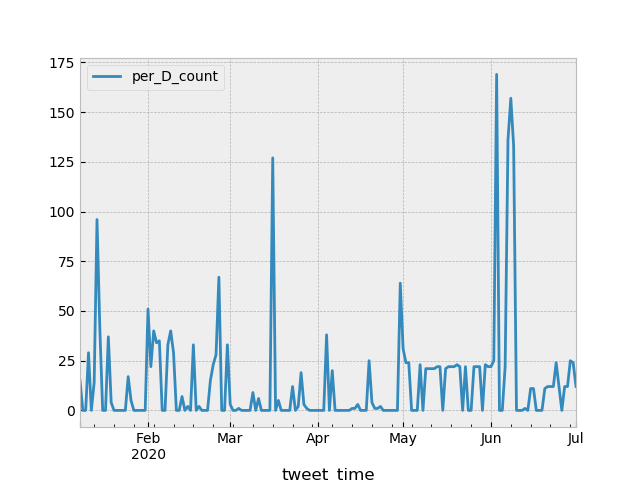

In [12]:
make_timeline((grouped.get_group(c1)),
              'D').plot()

<IPython.core.display.Javascript object>


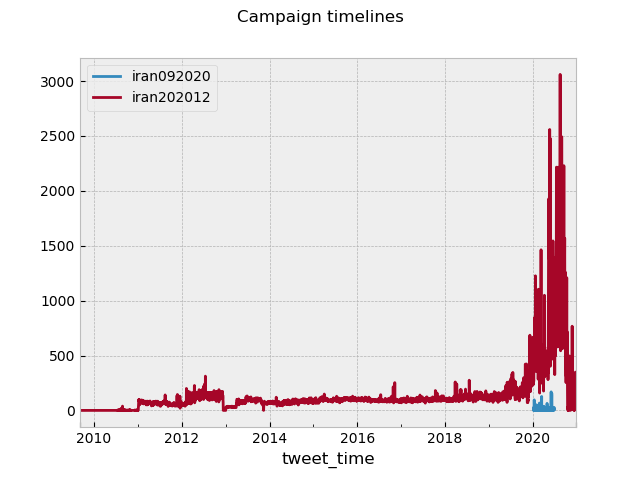

Text(0.5, 0.98, 'Campaign timelines')

In [13]:
fig, ax = plt.subplots()

for group in keys:
    (make_timeline((grouped.get_group(group)),
                  'D')
     .rename(columns={'per_D_count': '{}'.format(group)})
    ).plot(ax=ax)


fig.suptitle('Campaign timelines')

In [16]:
start = periods[0][0]
end = periods[0][1]
mask = (campaign['tweet_time'] >= start) & (campaign['tweet_time'] <= end)
overlap = (campaign
          .loc[mask]
          )
overlap_grouped = (overlap
          .groupby('campaign')
          )
overlap_grouped.size()

campaign
iran092020      2450
iran202012    111899
dtype: int64

<IPython.core.display.Javascript object>


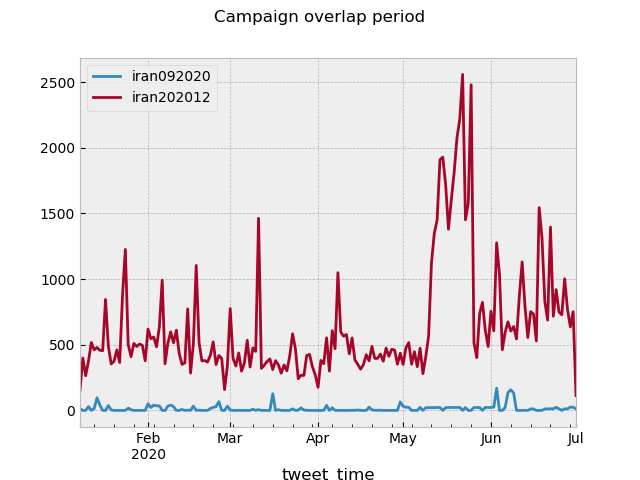

Text(0.5, 0.98, 'Campaign overlap period')

In [17]:
fig, ax = plt.subplots()

for group in keys:
    (make_timeline((overlap_grouped.get_group(group)),
                  'D')
     .rename(columns={'per_D_count': '{}'.format(group)})
    ).plot(ax=ax)


fig.suptitle('Campaign overlap period')

<IPython.core.display.Javascript object>


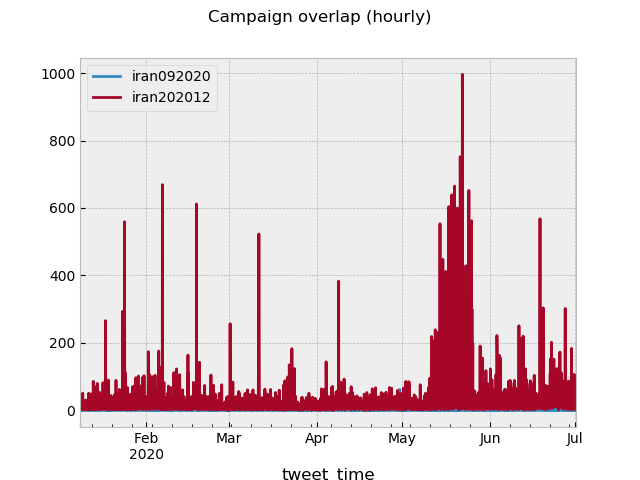

Text(0.5, 0.98, 'Campaign overlap (hourly)')

In [18]:
fig, ax = plt.subplots()

for group in keys:
    (make_timeline((overlap_grouped.get_group(group)),
                  'H')
     .rename(columns={'per_H_count': '{}'.format(group)})
    ).plot(ax=ax)


fig.suptitle('Campaign overlap (hourly)')

### Top day for Sept. release campaign

In [19]:
time_group1 = ((grouped.get_group(c1))
             .reset_index()
             .set_index('tweet_time')
             .resample('D')
            )
top_day1 = time_group1.size().sort_values(ascending=False).idxmax()

top_day_tweets = time_group1.get_group(top_day1)[['userid','tweet_text','hashtags']]

In [20]:
top_day_tweets['tweet_text']

tweet_time
2020-06-03 00:02:00    #black_lives_matter https://t.co/UJWCaJbPXn
2020-06-03 00:03:00    #black_lives_matter https://t.co/zzJS4kytCW
2020-06-03 14:56:00    #black_lives_matter https://t.co/VAO6kcQrXM
2020-06-03 15:01:00    #black_lives_matter https://t.co/exO1WAHp69
2020-06-03 15:01:00    #black_lives_matter https://t.co/C4Z0QJXDUi
                                          ...                     
2020-06-03 22:38:00    #black_lives_matter https://t.co/4tSzLN1xil
2020-06-03 22:38:00    #black_lives_matter https://t.co/rCiSM9sReR
2020-06-03 22:38:00    #black_lives_matter https://t.co/9JnxstuMb3
2020-06-03 22:38:00    #black_lives_matter https://t.co/qtfuvyDL7Y
2020-06-03 22:43:00    #black_lives_matter https://t.co/y8OlRvhiax
Name: tweet_text, Length: 169, dtype: string

<IPython.core.display.Javascript object>


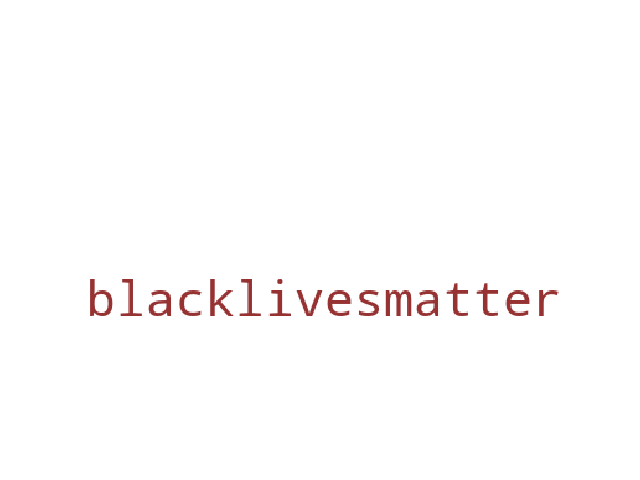

In [21]:
# can't do b/c it's entirely hashtags and urls
#fig = vis_from_series(top_day_tweets['tweet_text'])

fig = vis_from_series(top_day_tweets['hashtags'].apply(long_string))

### Compared to Dec. release

In [24]:
time_group2 = ((grouped.get_group(c2))
             .reset_index()
             .set_index('tweet_time')
             .resample('D')
            )
june3 = time_group2.get_group(top_day1)
print(june3['tweet_text'])

tweet_time
2020-06-03 00:10:00    La gran oleada de protestas por la muerte de #...
2020-06-03 00:33:00    RT @irXcL8Y80STibhjlS3a48BahFUg3yqPT+XtTxkpLL8...
2020-06-03 00:53:00    La #Policia estadounidense reprime con violenc...
2020-06-03 00:54:00    RT @CoderIR81: We’ll trend #KhomeiniForAll tog...
2020-06-03 01:08:00                                  @Sh59662450 عوضی 😂😂
                                             ...                        
2020-06-03 23:07:00    El Conaicop denuncia que la presencia de tropa...
2020-06-03 23:17:00                       @Achtugnam @achtungam املا؟؟؟🤔
2020-06-03 23:23:00    El papa Francisco repudia el racismo arraigado...
2020-06-03 23:43:00    RT @irXcL8Y80STibhjlS3a48BahFUg3yqPT+XtTxkpLL8...
2020-06-03 23:49:00    Bolsonaro, el “Trump brasileño”, sigue una vez...
Name: tweet_text, Length: 1276, dtype: string


<IPython.core.display.Javascript object>


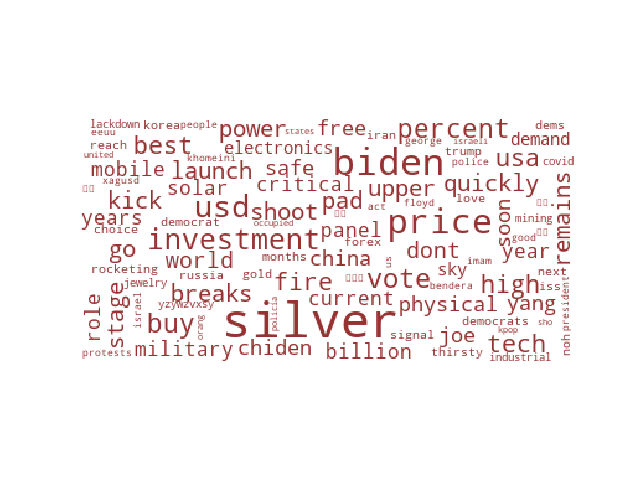

In [25]:
fig = vis_from_series(june3['tweet_text'])

### Top users

In [53]:
(campaign_users
.loc[campaign_users.index == top_user(grouped.get_group(c1))][fields]
).append(
campaign_users
.loc[campaign_users.index == top_user(grouped.get_group(c2))][fields])

,user_display_name,user_reported_location,user_profile_description,account_creation_date,account_language,follower_count,following_count
userid,,,,,,,
CH8ljNwytxIQAm7r8kH1J9+ykPUzrqe2L5uKhiA2cg=,CH8ljNwytxIQAm7r8kH1J9+ykPUzrqe2L5uKhiA2cg=,London,I write columns for the Sunday Times and books...,2020-01-25,en,352,559
213589457,HispanTV,Teherán,"Medio no corporativo, que se hace eco de las r...",2010-11-09,es,161512,31


In [33]:
(campaign
 .loc[campaign['userid'] == top_user(grouped.get_group(c1))]
)['tweet_text'].sample(20).to_list()

['The new Director of National Intelligence sent to Congress declassified transcripts of some of Michael Flynn’s calls with the Russian ambassador that occurred during the 2016 presidential transition\nhttps://t.co/BoqZqAqM6Q',
 '@Dadyycharming @OLANREFRONT247 @TwevePauLo I followed you please follow me.tnx',
 '@tofuksj @kookaineaddict_ I followed you.please follow me.tnx',
 '@bconnectmm @O__O2y @S__U2y I followed you.please follow me.tnx',
 'Welcome to the hotel California\nSuch a lovely place\nSuch a lovely face\nThey livin’ it up at the hotel California\nWhat a nice surprise, bring your alibis\nMirrors on the ceiling,\nThe pink champagne on ice\nAnd she said ’we are all just prisoners here, of our own device’ https://t.co/LA0Z30mBAI',
 '@rymrtlorbes @jaayeeeeem @CH8ljNwytxIQAm7r8kH1J9+ykPUzrqe2L5uKhiA2cg=\n\n followe me pls.follow back',
 '@heyitsmeJsslrBy @CH8ljNwytxIQAm7r8kH1J9+ykPUzrqe2L5uKhiA2cg=\n\n followe me pls.follow back',
 '@reisan_www I followed you.please follow me.tnx'

<IPython.core.display.Javascript object>


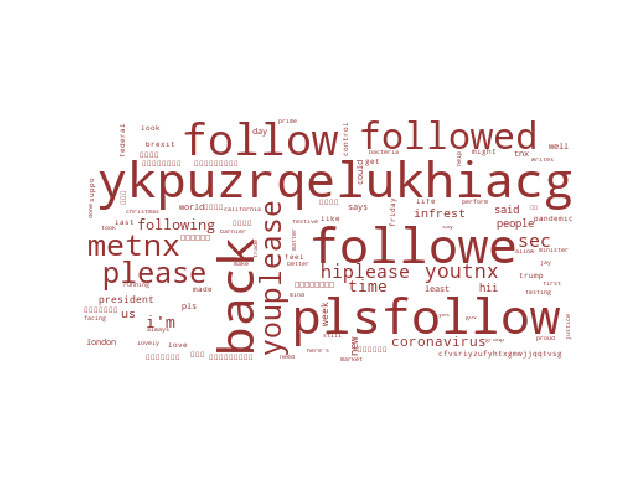

In [34]:
fig = vis_from_series((campaign
                    .loc[campaign['userid'] == top_user(grouped.get_group(c1))]['tweet_text']))

Versus Dec. release:

In [35]:
series = (campaign
         .loc[campaign['userid'] == top_user(grouped.get_group(c2))]['tweet_text'])

<IPython.core.display.Javascript object>


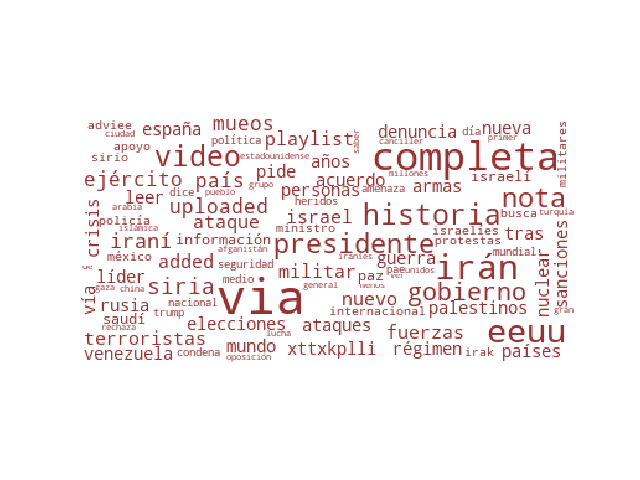

In [32]:
fig = vis_from_series(series)

In [36]:
c1_top_user = (campaign
              .loc[campaign['userid'] == top_user(grouped.get_group(c1))]
              )

In [37]:
mentioned_users = (c1_top_user['user_mentions']
            .explode()
            # melt wide table into duplicated tweets
            .reset_index()
            .melt(id_vars=['tweetid'],
                  value_name='mentioned_userid')
            # clean up
            .astype({'mentioned_userid':'string'})
            .drop(columns=['variable'])
          )

In [38]:
print(mentioned_users)

                  tweetid                              mentioned_userid
0     1269881973880864768                           1086980922023530497
1     1269881973880864768   CH8ljNwytxIQAm7r8kH1J9+ykPUzrqe2L5uKhiA2cg=
2     1270229092613468163                           1117726640740548608
3     1269910694549389313                           1257628920481869824
4     1269910694549389313                                     149733434
...                   ...                                           ...
1067  1231558833295806464                           1204707501889015808
1068  1247054749461106689                           1234041197204779008
1069  1223989795531173889                           1205923796810686464
1070  1239644334951145476                                     452151548
1071  1239644359307517953                                     452151548

[1072 rows x 2 columns]


<IPython.core.display.Javascript object>


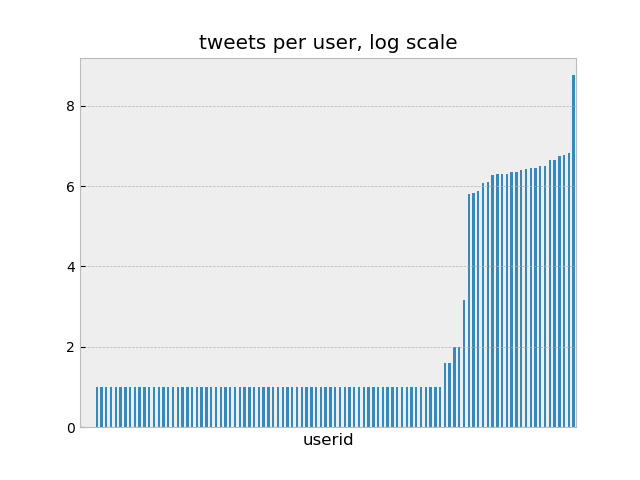

In [39]:
tweet_counts_per_user = ((grouped.get_group(c1))
                        .groupby('userid')
                        .size()
                        .sort_values(ascending=False)
                       )

fig, ax = plt.subplots()

np.log2(tweet_counts_per_user
 .sort_values()
).plot(ax=ax, kind='bar', xticks=([]), title='tweets per user, log scale')

fig.show()

In [42]:
preprocessed = (grouped
 .get_group(c1)
 .loc[:]['tweet_text']
 .apply(preprocess_string, special_tokens=True)
)

In [43]:
non_empty = preprocessed[(preprocessed != ' ') & (preprocessed != '')]
print(non_empty.head(20))

tweetid
1251750659008933888     [AT]: with cities and states facing huge budg...
1239532259209871360     [AT]: congrats, carrie! [HTAG] [HTAG] [HTAG] ...
1239532222144827395     [AT]: check out my new music video for [HTAG]...
1239523596957036544        [AT]: 🙊 haha- thank you for having me!! [URL]
1239523637629247489     [AT]: throwback to feel me on the revival tou...
1232190804589973504     [AT]: guys, i’ve been working on this special...
1232543748036419584     [AT]: rare - a edit is out friday! 🦋 [AT] [UR...
1232573628363018240     [AT]: rare - a edit is out friday! 🦋 [AT] [UR...
1269881973880864768    [AT] [AT]+ykpuzrqelukhiacg=\n\n followe me pls...
1270229092613468163    [AT] braelynn please followe me.i followed you...
1269910694549389313           [AT] [AT] i followed you. please follow me
1269864938522185730    [AT] [AT]+ykpuzrqelukhiacg=\n\n followe me pls...
1269882129451749377    [AT] [AT]+ykpuzrqelukhiacg=\n\n followe me pls...
1256085248292651009    [AT] [AT]+lsmhdc+ddg

vectorizing...
LDA:
n_samples: 2000
n_features: 1000
n_components: 6


<IPython.core.display.Javascript object>


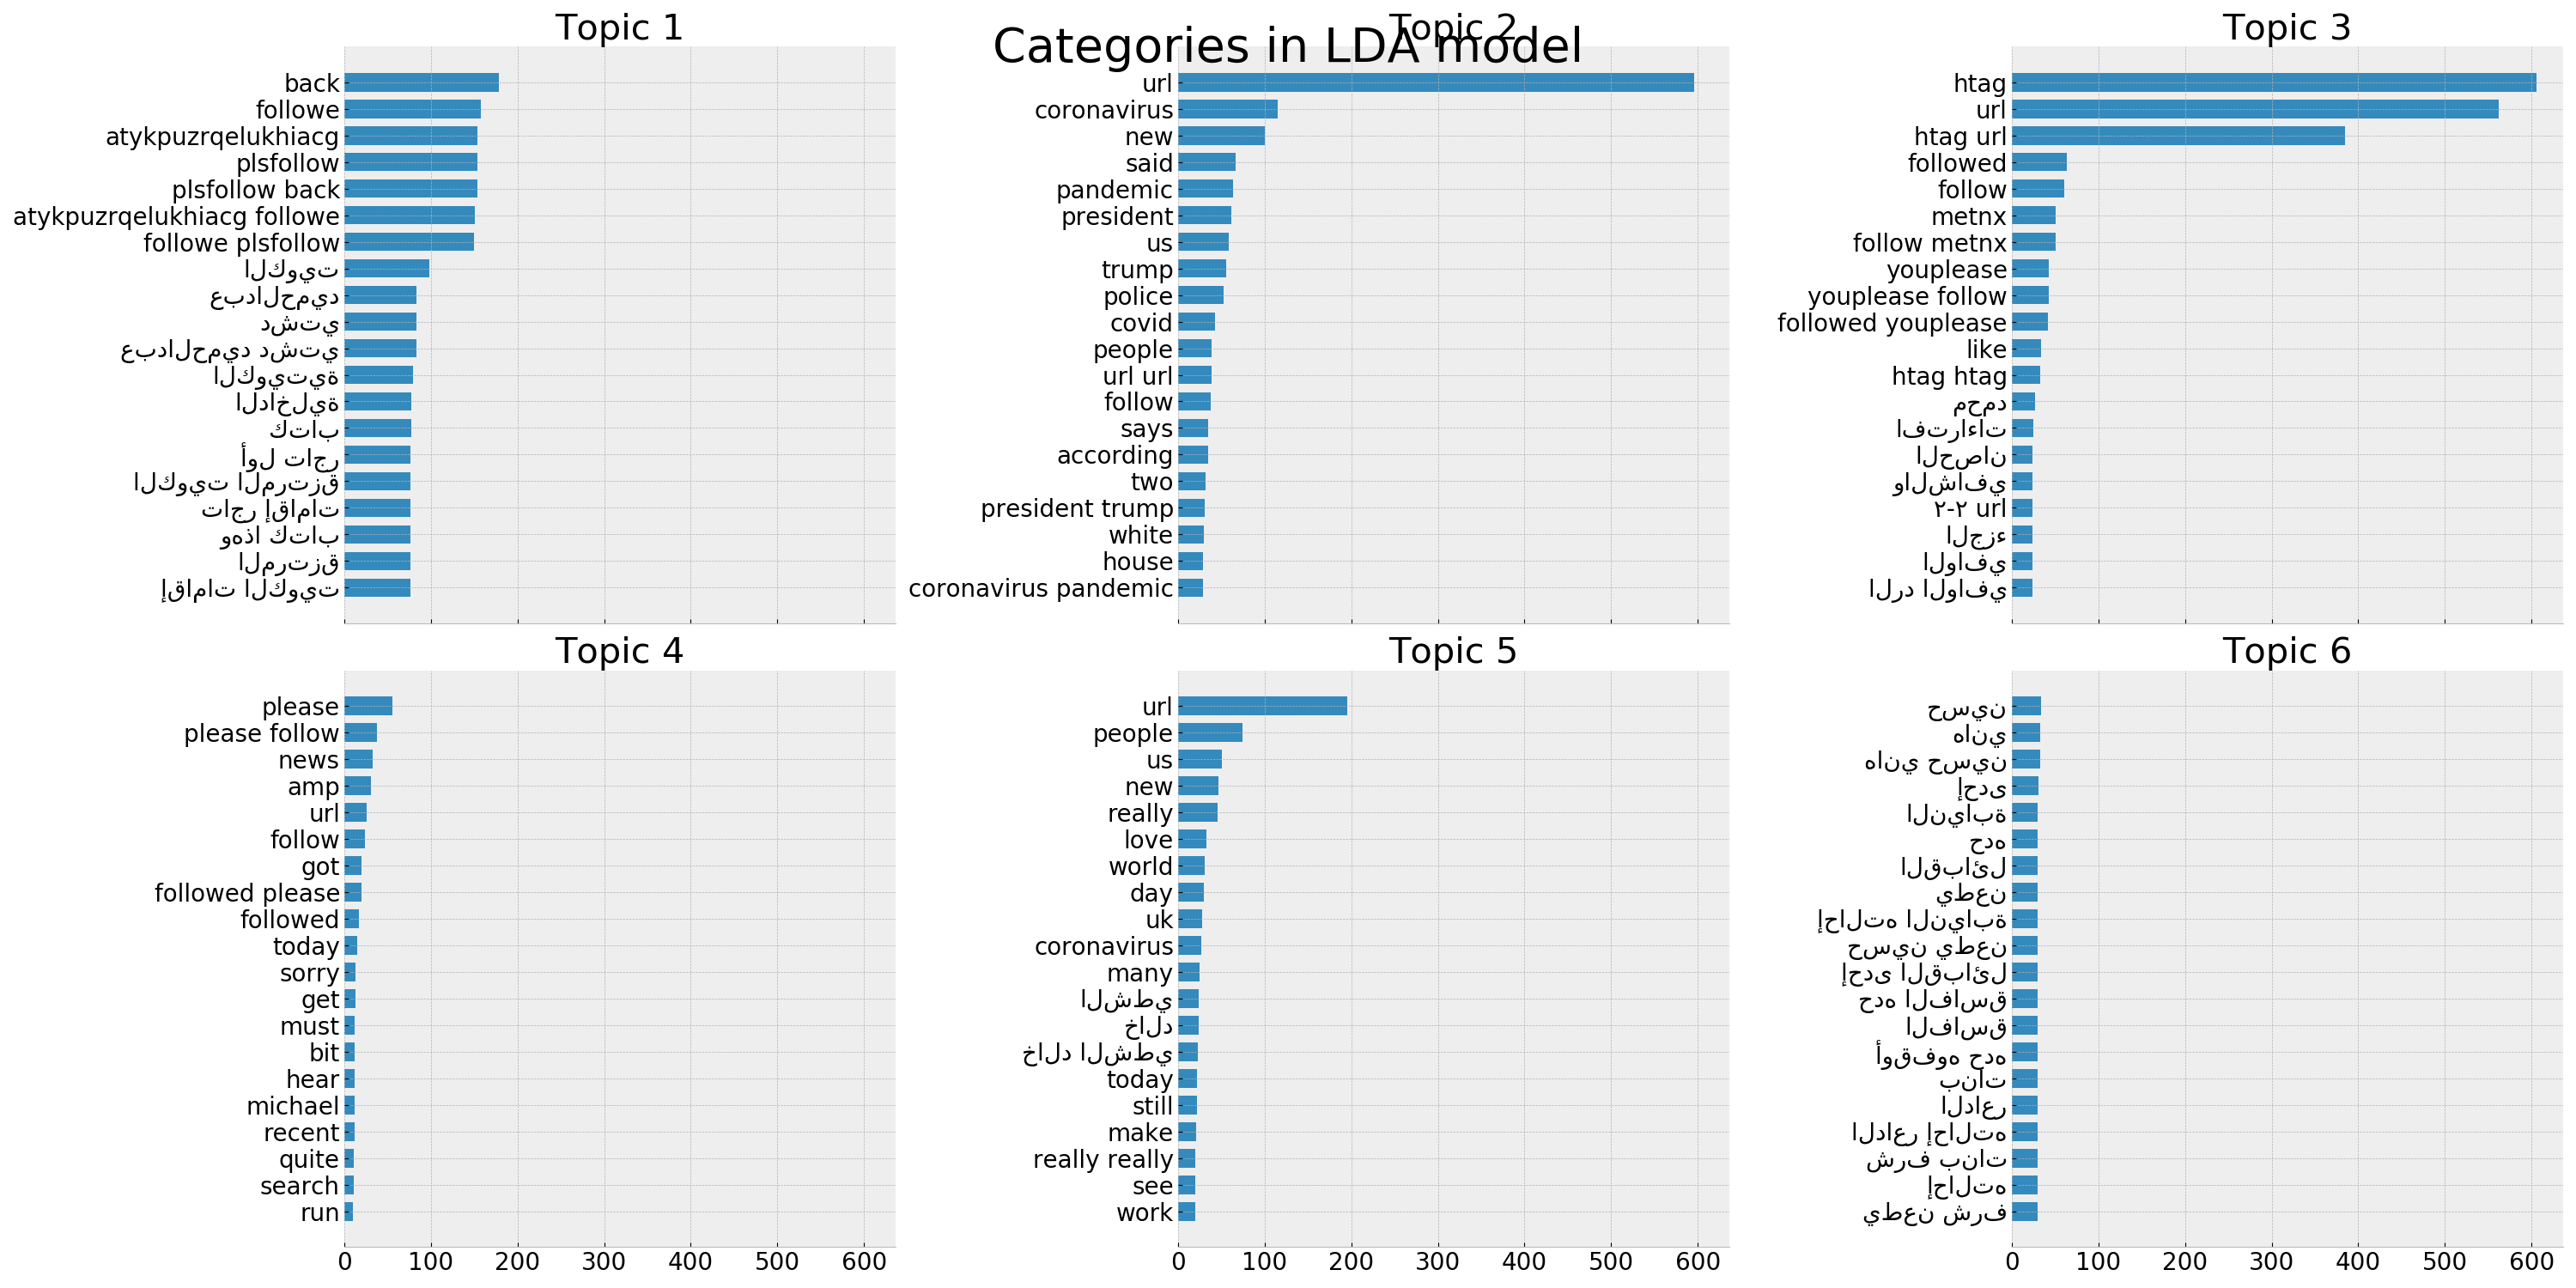

In [44]:
extract_topics(non_empty,
               apply_preprocessing=False,
               n_components=6)